In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import AJA as aja
from torch_geometric.loader import DataLoader
import pandas as pd

In [2]:
# charge les data frame brut (avec bert par défaut mais on peut l'enlever)

df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

In [3]:
# on bricole ses data frame en définissant des fonction qui prennent en entré un dataframe
# et donne en sortie un dataframe
# c'est dans ces fonctions qu'on extrait les features 

from sklearn.preprocessing import StandardScaler


# fonction d'extraction de feature pour les noeuds
def f(df):
    # il faut bien garder les colonnes 'transcription' 'line' et 'label
    # à part ces colonnes, toute colonne numérique dans le df rennvoyé sera utilisée comme feature
    
    scaler = StandardScaler()

    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker')
    df = df.drop('speaker_int', axis=1)
    df = df.drop('speaker_text', axis=1)
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df

# fonction d'extraction de feature pour les arrêtes
def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [4]:
# on crée les graphes de train, validation et test en donnant les fonctions d'feature-extraction
# de features et le ratio de validation (les vraies données de bases sont rechargées
# et la même transformation est appliquée au train et au test !) 

train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

In [5]:
# on check la forme des input
train_graphs['TS3008a']

Data(x=[471, 389], edge_index=[32], y=[471])

In [7]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [32]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.threshold = 0.5
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dense1 = nn.Linear(20,1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        return x

    def set_threshold(self, t):
        self.threshold = t

In [33]:
# Charger l'extension autoreload
%load_ext autoreload

# Configurer autoreload pour recharger tous les modules avant l'exécution de chaque cellule
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# on instancie le modèle
model = NodeClassifier(32,389)

# on définie la fonction de perte et l'optimiseur
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

alpha = 0.2  # Paramètre de pondération (ajustez selon votre cas)
gamma = 5  # Paramètre de focalité (ajustez selon votre cas)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')


model.set_threshold(0.6)

# on entraine !

states = []

for epoch in range(7):
    loss = aja.train(model, train_graphs, optimizer, criterion)
    print('- Epoch', f'{epoch:03d}', '-')
    print('Loss:',  f'{loss:.4f}')
    f1_train = aja.f1_score_moyen(model, train_graphs)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    print('F1 train:', f1_train)
    print('F1 valid:', f1_valid)
    torch.save(model.state_dict(), "training_states/"+str(epoch) + ".pth")
    print('')

- Epoch 000 -
Loss: 51.5589
F1 train: 0.5731844305566067
F1 valid: 0.5780553525506459



-------------------------
Analyse des performance du modèle :
-------------------------
F1-score: 0.5719699672699313


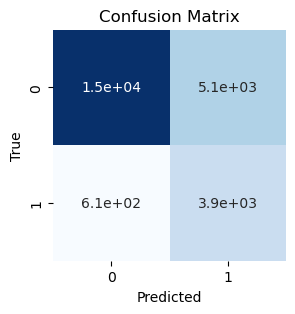

In [28]:
# on peut revenir à un modèle intermédiaire pour éviter l'overfitting
epoch_opt = 6
model.load_state_dict(torch.load("training_states/"+str(epoch_opt)+".pth"))

# on analyse le modèle
aja.analyse_model(model, validation_graphs)

In [25]:
# quand on est content on fait une submission !

aja.make_test_csv_submission(model, test_graphs, 'new_loss')